In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
from scipy.spatial.distance import cdist
from src.Graph import GeneGraph 

/home/qinxianhan/.conda/envs/sc/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def read_spatial_expression(file,sep='\s+',
                            num_exp_genes=0.01, num_exp_spots=0.01, min_expression=1,
                            drop = False):
    
    '''
    Read raw data and returns pandas data frame of spatial gene express
    and numpy ndarray for single cell location coordinates; 
    Meanwhile processing raw data.
    
    :param file: csv file for spatial gene expression; 
    :rtype: coord (spatial coordinates) shape (n, 2); data: shape (n, m); 
    '''
    counts = pd.read_csv(file, sep=sep, index_col = 0)
    print('raw data dim: {}'.format(counts.shape))

    num_spots = len(counts.index)
    num_genes = len(counts.columns)
    min_genes_spot_exp = round((counts != 0).sum(axis=1).quantile(num_exp_genes))
    print("Number of expressed genes a spot must have to be kept " \
    "({}% of total expressed genes) {}".format(num_exp_genes, min_genes_spot_exp))
    
    mark_points = np.where((counts != 0).sum(axis=1) < min_genes_spot_exp)[0]
    print("Marked {} spots".format(len(mark_points)))
    
    if len(mark_points)>0:
        noiseInd = [counts.shape[0]-1-i for i in range(len(mark_points))]
        if drop == False:
            temp = [val.split('x') for val in counts.index.values]
            coord = np.array([[float(a[0]), float(a[1])] for a in temp])

            similar_points=np.argsort(cdist(coord[mark_points,:],coord),axis=1)[:,1]
            for i,j in zip(mark_points,similar_points):
                counts.iloc[i,:]=counts.iloc[j,:]
        
            mark_counts=counts.iloc[mark_points,:]
            dropped_counts = counts.drop(counts.index[mark_points])
            counts=pd.concat([dropped_counts,mark_counts])  
            
        else:    
            counts = counts[(counts != 0).sum(axis=1) >= min_genes_spot_exp]
    else:
        counts = counts
        noiseInd =[] 
    
    # Spots are columns and genes are rows
    counts = counts.transpose()
    # Remove noisy genes
    min_features_gene = round(len(counts.columns) * num_exp_spots) 
    print("Removing genes that are expressed in less than {} " \
    "spots with a count of at least {}".format(min_features_gene, min_expression))
    counts = counts[(counts >= min_expression).sum(axis=1) >= min_features_gene]
    print("Dropped {} genes".format(num_genes - len(counts.index)))
    
    temp = [val.split('x') for val in counts.columns.values]
    coord = np.array([[float(a[0]), float(a[1])] for a in temp])

    data=counts.transpose()

    return coord,data, noiseInd

In [3]:
data_dir = '../dataset/MOB-breast_cancer/Rep11_MOB_count_matrix-1.tsv'
locs,data,_=read_spatial_expression(data_dir)
locs_df = pd.DataFrame(locs,columns=['imagerow', 'imagecol'])
locs_df.index = data.index
adata = sc.AnnData(X=data, obs=locs_df)

raw data dim: (262, 16218)
Number of expressed genes a spot must have to be kept (0.01% of total expressed genes) 3375
Marked 3 spots
Removing genes that are expressed in less than 3 spots with a count of at least 1
Dropped 1559 genes


In [4]:
# Suppose new_index is your new index
new_index = ["array_row", "array_col"]
adata.obs.rename(columns={"imagerow": new_index[0], "imagecol": new_index[1]}, inplace=True)

In [5]:
target_gene = 'Myo5a'
exp = adata[:,target_gene].X.toarray()
gene_graph = GeneGraph(adata, target_gene, radius= 1)

Graph constructed


In [9]:
label = gene_graph.mrf_with_icmem(beta=5)

100%|██████████| 10/10 [00:00<00:00, 23.76it/s]

[[10.22391174 14.93503131]
 [18.05049854 52.93443029]]


In [10]:
adata.obs['label'] = label

/home/qinxianhan/.conda/envs/sc/lib/python3.11/site-packages/scanpy/plotting/_utils.py:715: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  color = color[sort]


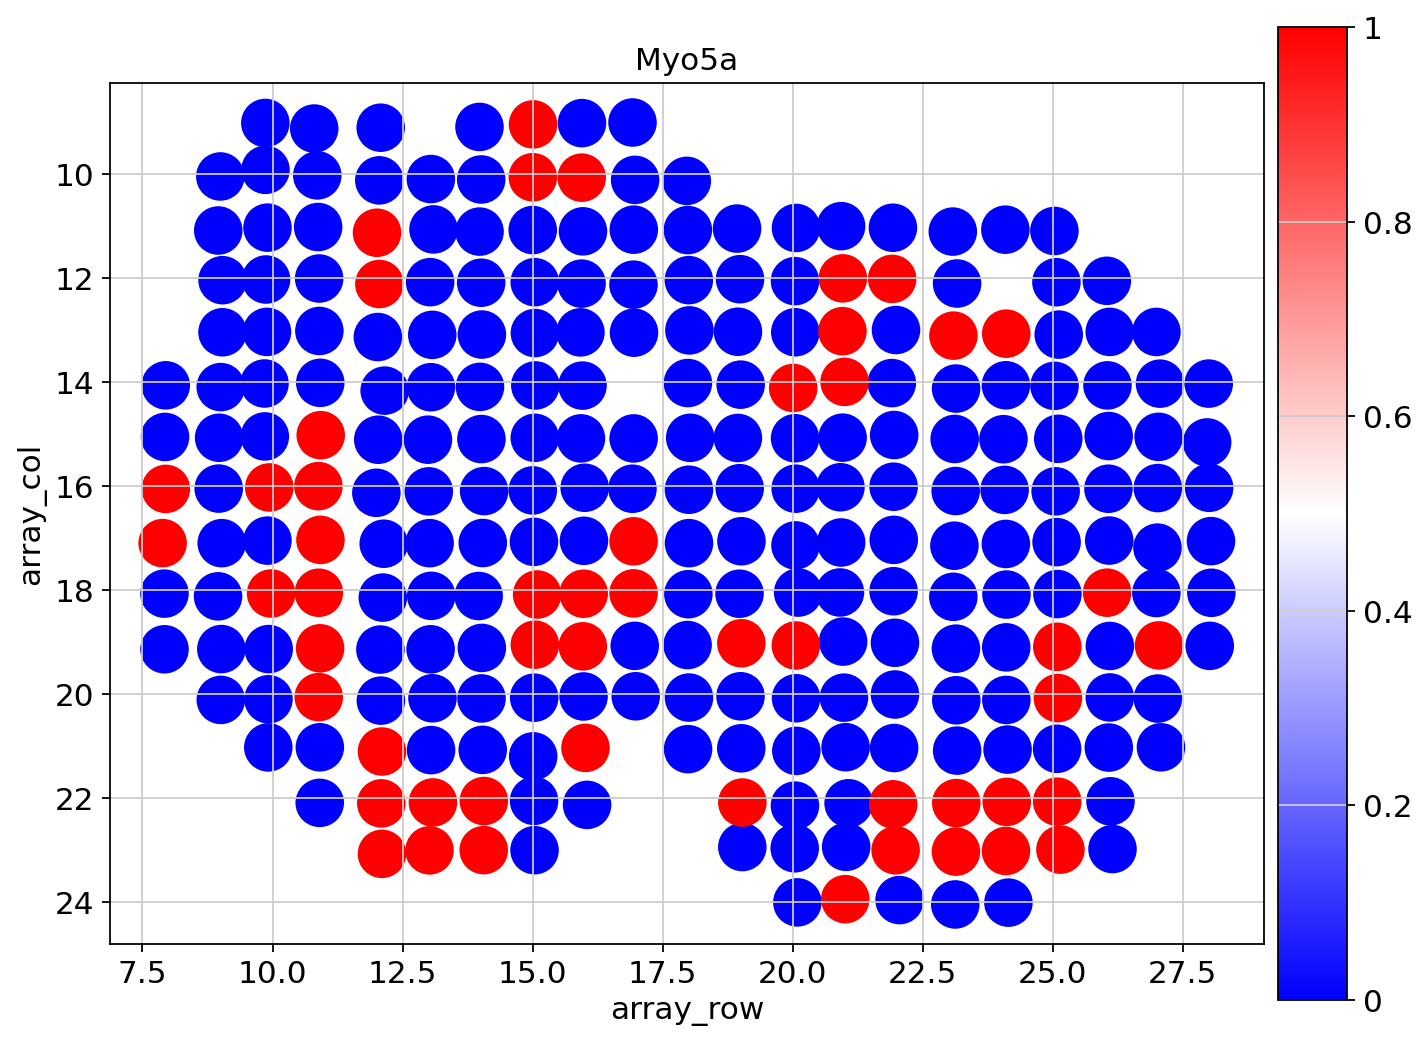

In [11]:
sc.set_figure_params(facecolor="white", figsize=(8, 8))
ax=sc.pl.scatter(adata,alpha=1,x="array_row",y="array_col", color = "label",
                 title=target_gene,show=False,size=500000/adata.shape[0],
                color_map='bwr')
ax.set_aspect('equal', 'box')
ax.axes.invert_yaxis()

In [12]:
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans

In [13]:
gmm = GaussianMixture(n_components=2).fit(exp)
gpred = gmm.predict(exp)
adata.obs["gmm"] = gpred
kmeans = KMeans(n_clusters=2).fit(exp)
kpred = kmeans.predict(exp)
adata.obs["kmeans"] = kpred

/home/qinxianhan/.conda/envs/sc/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [26]:
print(gene_graph.exp.shape, gene_graph.graph.shape, gene_graph.label.shape)

(262, 1) (262, 262) (262,)


In [33]:
exp = gene_graph.exp 
graph = gene_graph.graph

In [40]:
def impute(exp, graph, label):
    exp = exp.astype(np.float64)
    weight = [0.8, 0.2]
    cellNum = graph.shape[0]
    for i in range(cellNum):
        neighbor_indices = graph[i].indices
        for neighbor in neighbor_indices:
            flag = np.abs(label[i] - label[neighbor])
            exp[i] += weight[flag] * exp[neighbor]
    return exp
impute(exp, graph, label)

array([[  25.6       ],
       [  58.8       ],
       [ 105.872     ],
       [  39.6       ],
       [  76.824     ],
       [  25.4       ],
       [  38.6       ],
       [  71.776     ],
       [  28.        ],
       [  21.6       ],
       [  59.52      ],
       [   7.2       ],
       [  40.6       ],
       [  76.68      ],
       [  74.8       ],
       [  28.8       ],
       [ 156.712     ],
       [ 142.344     ],
       [  35.2       ],
       [  82.688     ],
       [  73.288     ],
       [ 181.75104   ],
       [  31.6       ],
       [  29.        ],
       [  68.904     ],
       [ 229.73472   ],
       [  96.824     ],
       [ 169.22656   ],
       [ 294.2862464 ],
       [ 608.19875482],
       [ 122.3088    ],
       [  54.6       ],
       [ 116.33472   ],
       [ 212.924672  ],
       [  70.12      ],
       [ 333.81152768],
       [  46.4       ],
       [ 509.68859986],
       [  32.4       ],
       [  36.6       ],
       [ 326.41152768],
       [ 143.064

In [46]:
imputed = impute(exp, graph, label)

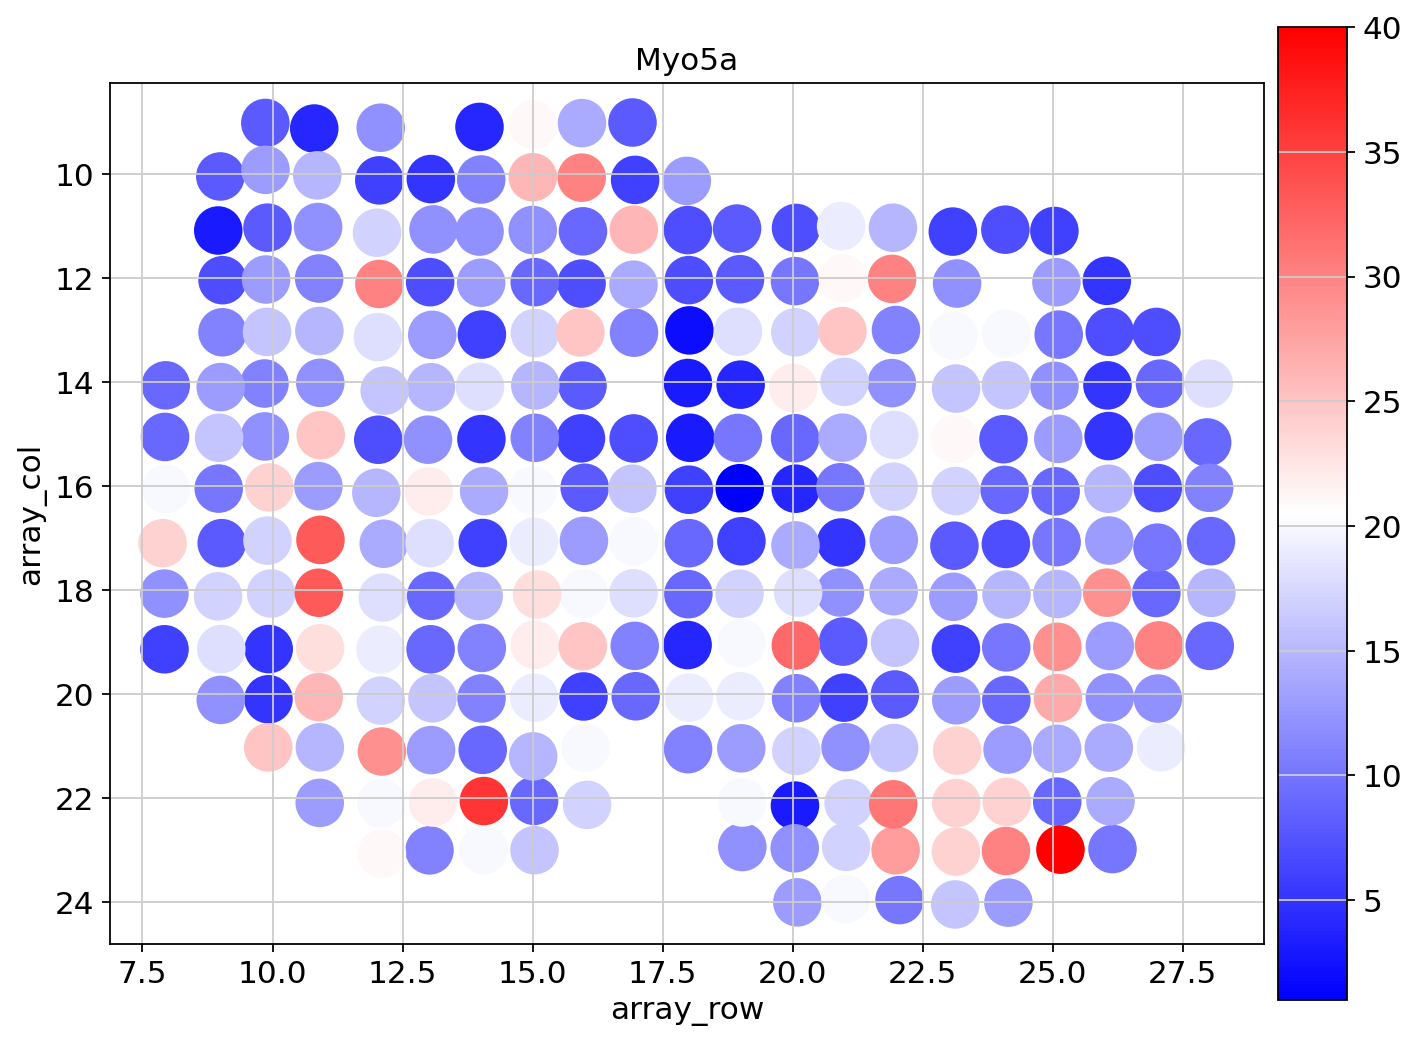

In [42]:
sc.set_figure_params(facecolor="white", figsize=(8, 8))
ax=sc.pl.scatter(adata,alpha=1,x="array_row",y="array_col", color = target_gene,
                 title=target_gene,show=False,size=500000/adata.shape[0],
                color_map='bwr')
ax.set_aspect('equal', 'box')
ax.axes.invert_yaxis()

/home/qinxianhan/.conda/envs/sc/lib/python3.11/site-packages/scanpy/plotting/_utils.py:715: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  color = color[sort]


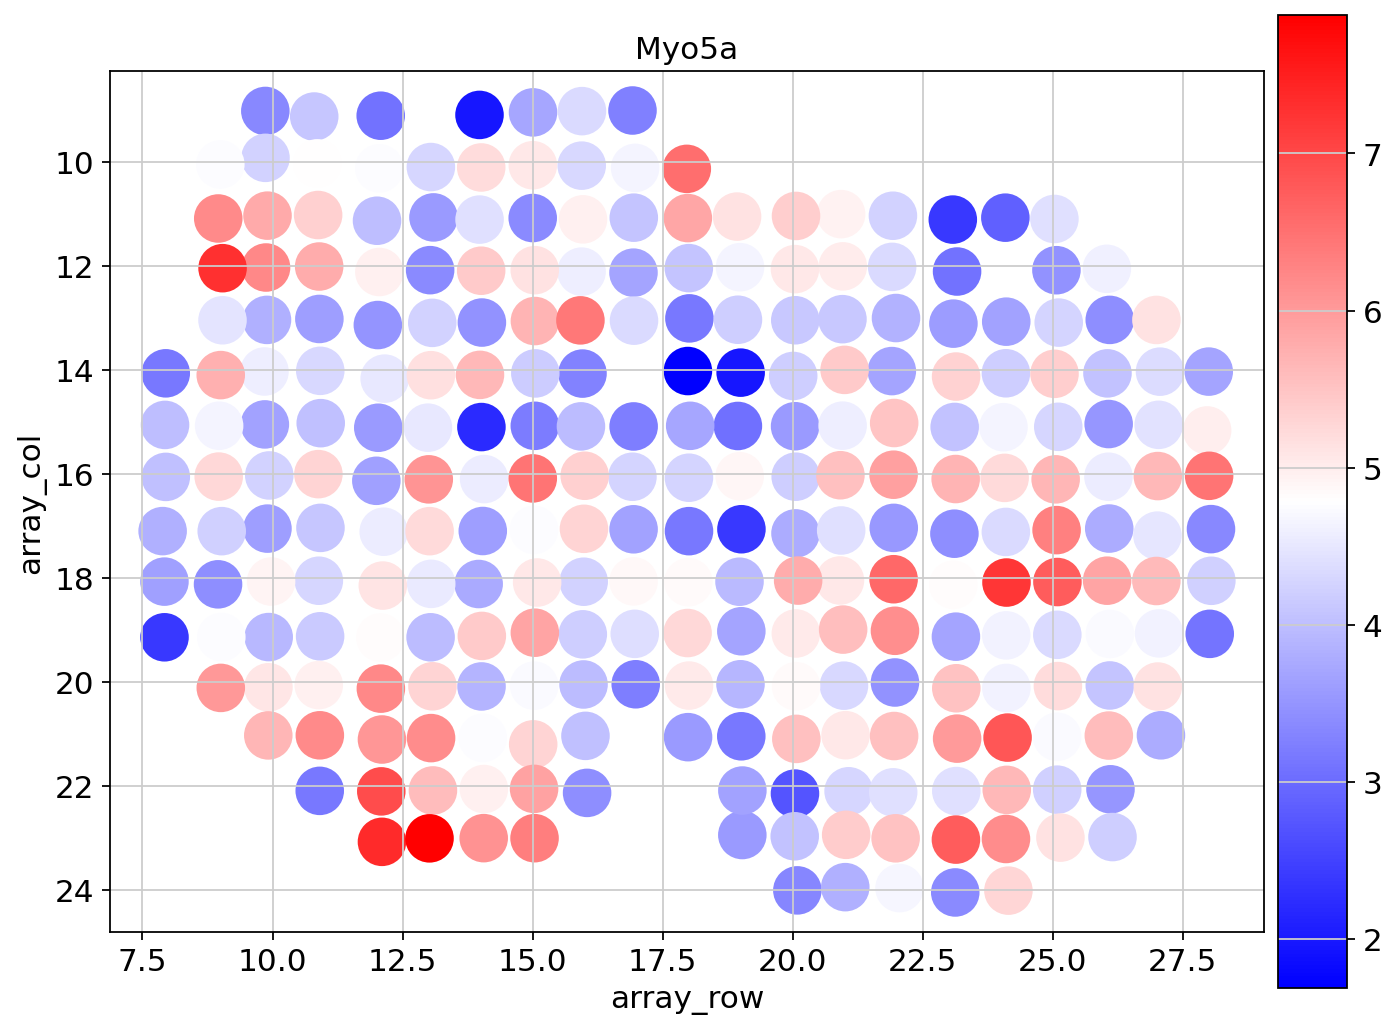

In [52]:
adata.obs["imputed"] = imputed 
sc.set_figure_params(facecolor="white", figsize=(8, 8))
ax=sc.pl.scatter(adata,alpha=1,x="array_row",y="array_col", color = "imputed",
                 title=target_gene,show=False,size=500000/adata.shape[0],
                color_map='bwr')
ax.set_aspect('equal', 'box')
ax.axes.invert_yaxis()

In [49]:
imputed = np.log(imputed)

In [63]:
graph.toarray().sum(1)

array([2., 3., 3., 3., 2., 2., 2., 3., 3., 1., 3., 1., 2., 3., 2., 2., 3.,
       3., 3., 3., 4., 3., 3., 3., 2., 4., 4., 3., 3., 3., 3., 2., 2., 4.,
       3., 4., 3., 3., 1., 2., 2., 3., 3., 2., 3., 2., 3., 3., 2., 4., 2.,
       3., 3., 2., 2., 2., 3., 3., 1., 2., 3., 3., 3., 3., 3., 4., 4., 3.,
       4., 4., 4., 3., 3., 3., 2., 3., 4., 3., 4., 4., 5., 3., 3., 2., 2.,
       4., 4., 4., 5., 2., 2., 2., 3., 2., 3., 2., 2., 2., 4., 3., 2., 3.,
       1., 3., 1., 2., 5., 4., 2., 3., 3., 4., 3., 3., 4., 2., 3., 2., 1.,
       1., 3., 4., 3., 2., 3., 3., 4., 1., 3., 3., 3., 1., 3., 2., 3., 3.,
       1., 3., 3., 3., 4., 3., 3., 4., 4., 4., 2., 2., 3., 3., 3., 4., 4.,
       2., 3., 4., 3., 3., 4., 2., 3., 2., 3., 3., 3., 4., 3., 5., 4., 5.,
       3., 3., 4., 3., 3., 3., 4., 4., 3., 4., 4., 4., 4., 3., 2., 2., 3.,
       2., 2., 3., 4., 2., 3., 2., 3., 3., 5., 4., 1., 4., 4., 1., 3., 3.,
       3., 3., 4., 3., 2., 4., 2., 3., 4., 2., 1., 2., 1., 2., 3., 3., 2.,
       3., 4., 3., 2., 4.